In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from typing import List
from datetime import date, datetime

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_squared_error,
    mean_absolute_error
)

In [2]:
TRAIN_FILE_PATH = "/kaggle/input/tabular-playground-series-jan-2022/train.csv"
TEST_FILE_PATH = "/kaggle/input/tabular-playground-series-jan-2022/test.csv"
train_val = pd.read_csv(TRAIN_FILE_PATH)
test = pd.read_csv(TEST_FILE_PATH)

def smape(t, p):
    return 100 / len(t) * np.sum(2 * np.abs(p - t) / (np.abs(t) + np.abs(p)))

def get_month_day(date: str) -> List[int]:
    return [int(v) for v in date.split("-")]

def split_train_val(train_val):
    mask = train_val["date"] < "2018-01-01"
    return train_val[mask].copy(), train_val[~mask].copy()
            
def prepare(data):
    data.loc[:, ["year", "month", "day"]] = data["date"].map(get_month_day).tolist()
    data["weekday"] = data["date"].map(
        lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    )
    
    leap_year_mask = ~data["date"].str.contains("-02-29")
    return data[leap_year_mask].reset_index(drop=True).copy()

train_val = prepare(train_val)
test = prepare(test)

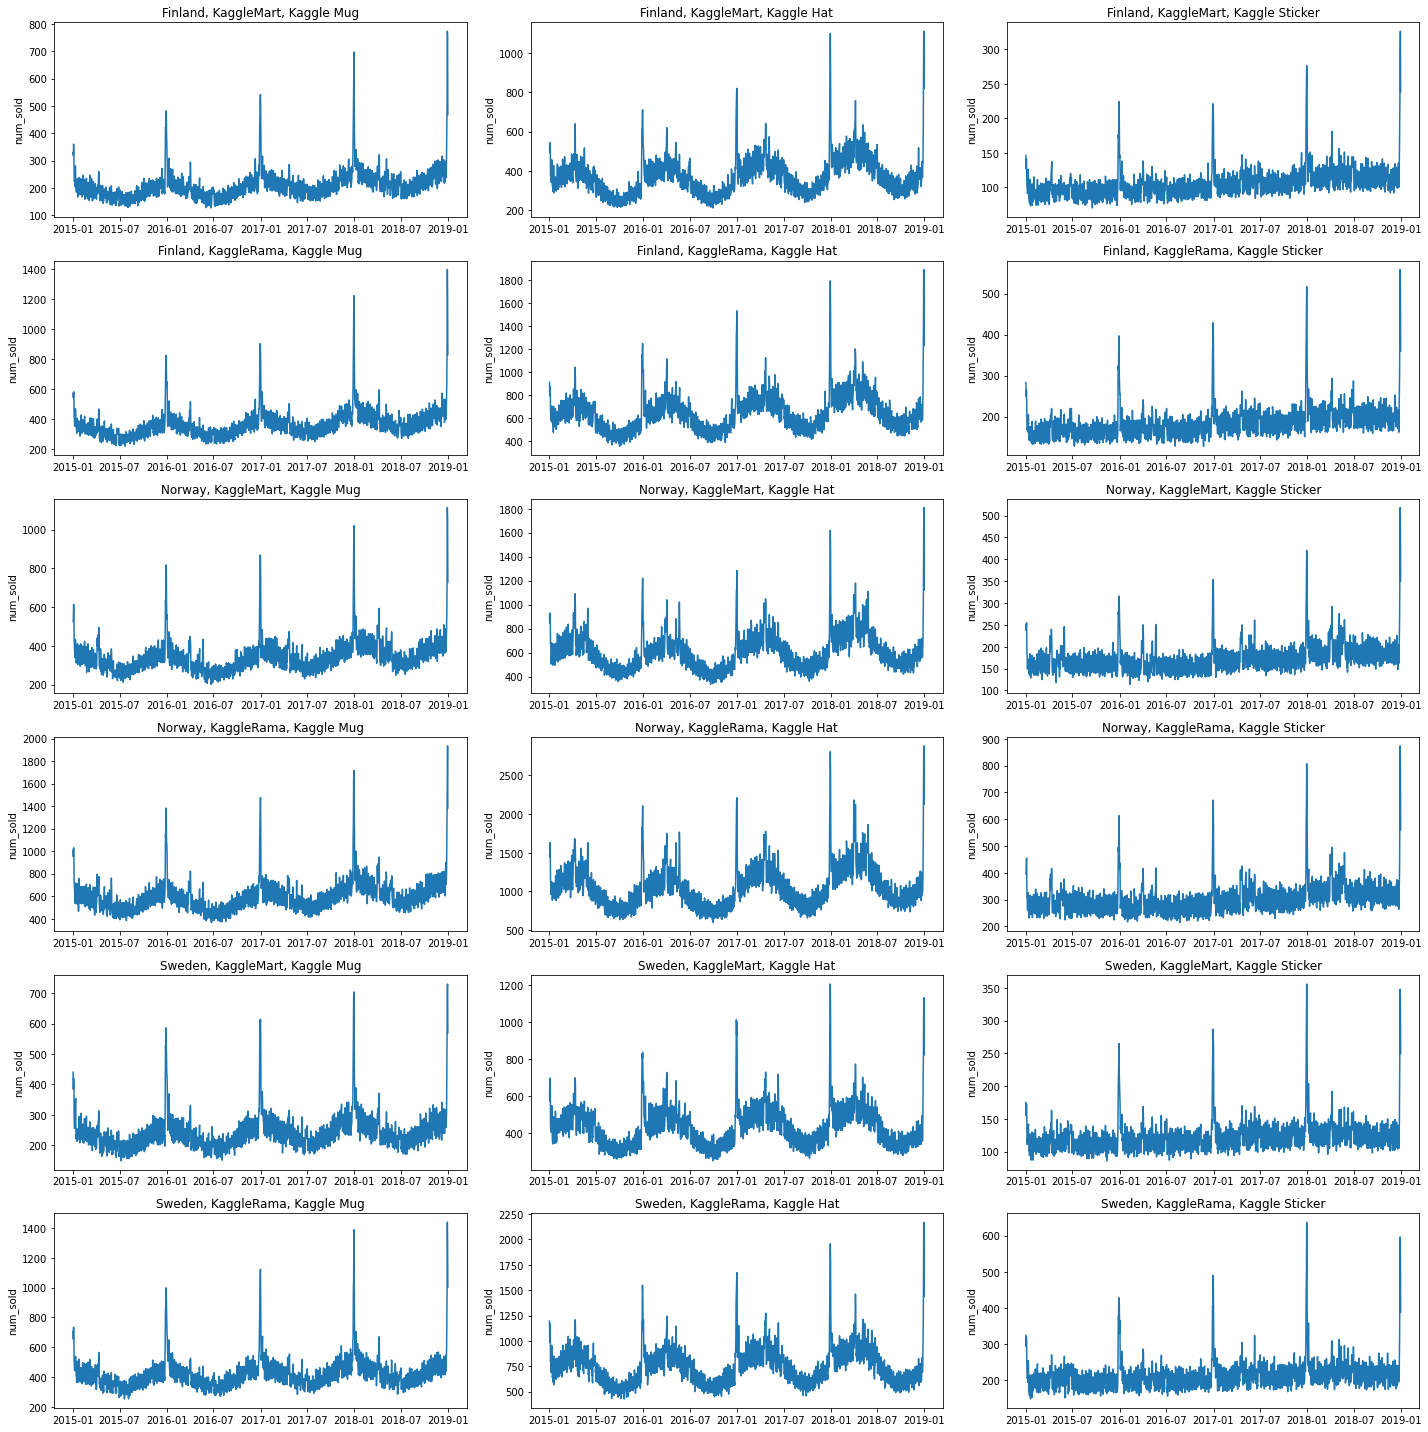

In [3]:
def show(data):
    all_ = itertools.product(
        data["country"].unique(),
        data["store"].unique(),
        data["product"].unique()
    )
    
    fig, ax = plt.subplots(6, 3, figsize=(20, 20))
    
    for (country, store, product), a in zip(all_, ax.flatten()):
        mask = (
            (data["country"] == country) &
            (data["store"] == store) &
            (data["product"] == product)
        )
        x = pd.to_datetime(data.loc[mask, "date"])
        y = data.loc[mask, "num_sold"]
        a.plot(x, y)
        a.set_title(f"{country}, {store}, {product}")
        a.set_ylabel("num_sold")
    
    plt.tight_layout()
    plt.show()

show(train_val)

In [4]:
def show_counts(data):
    return data.groupby(["country", "store", "product"]).agg(count=("row_id", "count"))

show_counts(test).merge(
    show_counts(train_val),
    right_index=True,
    left_index=True,
    suffixes=["_test", "_train_val"],
)

count_test  count_train_val
country store      product                                    
Finland KaggleMart Kaggle Hat             365             1460
                   Kaggle Mug             365             1460
                   Kaggle Sticker         365             1460
        KaggleRama Kaggle Hat             365             1460
                   Kaggle Mug             365             1460
                   Kaggle Sticker         365             1460
Norway  KaggleMart Kaggle Hat             365             1460
                   Kaggle Mug             365             1460
                   Kaggle Sticker         365             1460
        KaggleRama Kaggle Hat             365             1460
                   Kaggle Mug             365             1460
                   Kaggle Sticker         365             1460
Sweden  KaggleMart Kaggle Hat             365             1460
                   Kaggle Mug             365             1460
                   Kaggle Sticker         365             1460
        KaggleRama Kaggle Hat             365             1460
                   Kaggle Mug             365             1460
                   Kaggle Sticker         365             1460

In [5]:
train, val = split_train_val(train_val)
# 3 countries, 2 stores, 3 products = 18
print(train.shape, val.shape, test.shape, 18 * 365)

(19710, 10) (6570, 10) (6570, 9) 6570


In [6]:
def evaluate(y_true, y_pred):
    metrics = (
        ("MSE", mean_squared_error),
        ("MAE", mean_absolute_error),
        ("R2", r2_score),
        ("Explained Var", explained_variance_score),
        ("SMAPE", smape)
    )
    
    for name, fun in metrics:
        print(f"{name}: {fun(y_true, y_pred):.2f}")

In [7]:
def dummy_baseline(train, val):
    keys = ["country", "store", "product"]
    means = (
        train.groupby(keys)
             .agg({"num_sold": "mean"})
             .reset_index()
             .rename(columns={"num_sold": "pred_num_sold"})
    )
    return val.merge(means, left_on=keys, right_on=keys)

prediction = dummy_baseline(train, val)
evaluate(prediction["num_sold"].values, prediction["pred_num_sold"])

MSE: 19820.79
MAE: 77.41
R2: 0.77
Explained Var: 0.80
SMAPE: 16.46


In [8]:
def less_dummy_baseline(train, val):
    
    keys = ["country", "store", "product", "month", "day"]
    means = (
        train.groupby(keys)
             .agg({"num_sold": "mean"})
             .reset_index()
             .rename(columns={"num_sold": "pred_num_sold"})
    )
    return val.merge(means, left_on=keys, right_on=keys)

prediction = less_dummy_baseline(train, val)
evaluate(prediction["num_sold"].values, prediction["pred_num_sold"])

MSE: 9637.19
MAE: 60.69
R2: 0.89
Explained Var: 0.92
SMAPE: 14.52


In [9]:
def add_previous_year(left, right=None):
    keys = ["country", "store", "product", "month", "day", "year"]
    
    right = right if right is not None else left
    right = right[keys + ["num_sold"]].rename(columns={"num_sold": "num_sold_prev"})
    right["year"] = right["year"] + 1
    
    return left.merge(
        right,
        left_on=keys,
        right_on=keys,
        how="inner",
    )

In [10]:
add_previous_year(train_val).head()

,row_id,date,country,store,product,num_sold,year,month,day,weekday,num_sold_prev
0,6570,2016-01-01,Finland,KaggleMart,Kaggle Mug,370,2016,1,1,4,329
1,6571,2016-01-01,Finland,KaggleMart,Kaggle Hat,523,2016,1,1,4,520
2,6572,2016-01-01,Finland,KaggleMart,Kaggle Sticker,143,2016,1,1,4,146
3,6573,2016-01-01,Finland,KaggleRama,Kaggle Mug,618,2016,1,1,4,572
4,6574,2016-01-01,Finland,KaggleRama,Kaggle Hat,995,2016,1,1,4,911


In [11]:
def transform(train_val, test):

    transformer = ColumnTransformer(
        [
            ("cats", OneHotEncoder(), ["country", "store", "product", "weekday"]),
            ("num_sold_prev", StandardScaler(), ["num_sold_prev"])
        ]
    )

    train_, val_ = split_train_val(add_previous_year(train_val))
    test_ = add_previous_year(test, train_val)
    test_["num_sold"] = np.nan
    test_ = test_[train_.columns]

    X_train = transformer.fit_transform(train_)
    y_train = train_["num_sold"].values

    X_val = transformer.transform(val_)
    y_val = val_["num_sold"].values
    
    X_test = transformer.transform(test_)
    return X_train, y_train, X_val, y_val, X_test

In [12]:
X_train, y_train, X_val, y_val, X_test = transform(train_val, test)

In [13]:
def evaluate_sklearn_model(X_train, y_train, X_val, y_val, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print("Val:")
    evaluate(y_val, y_pred)
    print("Train")
    evaluate(y_train, model.predict(X_train))

In [14]:
model = SGDRegressor(penalty="l2")
evaluate_sklearn_model(X_train, y_train, X_val, y_val, model)

Val:
MSE: 5607.85
MAE: 47.21
R2: 0.93
Explained Var: 0.94
SMAPE: 14.15
Train
MSE: 4466.43
MAE: 42.77
R2: 0.93
Explained Var: 0.93
SMAPE: 13.97


In [15]:
gbr = model = GradientBoostingRegressor()
evaluate_sklearn_model(X_train, y_train, X_val, y_val, model)

Val:
MSE: 4523.89
MAE: 39.28
R2: 0.95
Explained Var: 0.95
SMAPE: 9.13
Train
MSE: 2883.00
MAE: 33.46
R2: 0.96
Explained Var: 0.96
SMAPE: 8.68


In [16]:
output = pd.DataFrame(
    {
        "row_id": test["row_id"],
        "num_sold": gbr.predict(X_test)
    }
)

In [17]:
output.to_csv("/kaggle/working/output_1.csv", index=False)